In [2]:
from model_utils import *

In [3]:
FILE = "./data/augmented_elmundo_1124.json"
DATASET_NAME = 'elmundo'
LOG_DIR = "./news-classification"
MAX_CATE_SIZE = 3000
MODEL_NAME = 'skimai/spanberta-base-cased'
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 128
LEARN_RATE = 3e-5
EPOCH = 3
TASK = 'further_pretrained'

In [4]:
import datetime
today = datetime.date.today().strftime("%m%d")
RESULT_DIR = 'results/{}-results-{}'.format(TASK,today)
SUB_DIR = '/{}-{}'.format(LEARN_RATE, MAX_SEQ_LENGTH)
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
if not os.path.exists("{}{}".format(RESULT_DIR,SUB_DIR)):
    os.makedirs("{}{}".format(RESULT_DIR,SUB_DIR))
OUTPUT_PATH = RESULT_DIR + SUB_DIR

In [4]:
# classifier label set

target_label = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
# source item label set
source_label = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
source_label_dic = {}
for idx, label in enumerate(source_label):
    source_label_dic[label] = idx

## Load Data

In [5]:
def load_test_data(path,cate_size,type='JSON',percentage=1):
    if type == "JSON":
        df = pd.read_json(path)
    else:
        df = pd.read_csv(path)
    df = df.iloc[np.random.permutation(len(df))]
    df.describe()
    labels = df['category'].tolist()
    contents = df['content'].tolist()
    label_dic = {}
    final_size = int(len(contents) * percentage)
    if percentage != 1:
        contents = contents[:final_size]
        labels = labels[:final_size]

    # itos                                        
    label_set = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
    # stoi
    for idx, label in enumerate(label_set):
        label_dic[label] = idx
    # shuffle
    idx_list = list(range(0, len(labels), 1))
    random.shuffle(idx_list)
    shuffled_labels = []
    shuffled_contents = []
    for idp in idx_list:
        shuffled_labels.append(labels[idp])
        shuffled_contents.append(contents[idp])
    print('Data loaded label:{} content:{} '.format(len(labels), len(contents)))
    return shuffled_labels, shuffled_contents, label_set, label_dic

In [6]:
class TestDataset(Dataset):
    def __init__(self,labels,inputs,origins,ldic):
        self.labels = labels
        self.origins = origins
        self.inputs = inputs
        self.ldic = ldic
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self,idx):
        y = self.labels[idx]
        y_encoded = torch.Tensor([self.ldic.get(y,-1)]).long().squeeze(0)
        res ={
            'input_ids':self.inputs[idx]['input_ids'][0],
            'attention_mask': self.inputs[idx]['attention_mask'][0],
            'origin_contents':self.origins[idx],
            'targets':y_encoded,
        }
        return res

In [7]:
# load test data and label info
labels,contents,lset,ldic = load_test_data(FILE,MAX_CATE_SIZE)
# encode
start = time.time()
encoding_list = pre_encode_list(MODEL_NAME,contents,MAX_SEQ_LENGTH)
print("encoding time costs: {}".format(time.time()-start))

# load valid dataset 
train_dataset = NewsCategoryDataset(labels, encoding_list, contents, ldic )
valid_dataset = NewsCategoryDataset(labels, encoding_list, contents, ldic, 'val')
test_dataset = NewsCategoryDataset(labels, encoding_list, contents, ldic, 'test')
print('data loaded \ntrain:{}\nvalid:{}\ntest:{}'.format(len(train_dataset),
                                                          len(valid_dataset),
                                                          len(test_dataset)))
# dataloader
train_val_loaders = {
    "train": DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True),
    "valid": DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False),
    "test": DataLoader(dataset=test_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False)
}

Data loaded label:214806 content:214806 


100%|██████████| 214806/214806 [00:48<00:00, 4428.99it/s]

Tokenizer loaded...
encoding time costs: 53.75099802017212
data loaded 
train:150364
valid:32222
test:32220


In [8]:
class FurtherPretrainClassifier(nn.Module):
    def __init__(self, model_name, source, source_num,target_num):
        super().__init__()
        config = RobertaConfig.from_pretrained(model_name, num_labels=target_num)
        self.model = RobertaForSequenceClassification(MODEL_NAME, source_num)
        state_dict = torch.load(source)
        self.model.load_state_dict(state_dict)
        print(self.model.MLP)
        self.model.MLP = nn.Linear(config.hidden_size, target_num)
        self.model.MLP.apply(weight_init)

    def forward(self, features, attention_mask=None, head_mask=None):
        assert attention_mask is not None, 'attention_mask is none'
        bert_output = self.model.bert(input_ids=features,
                                attention_mask=attention_mask,
                                head_mask=head_mask)

        hidden_state = bert_output[0]

        pool_output = hidden_state[:, 0]
        # print(pool_output)
        # print(pool_output.shape)
        logits = self.model.MLP(pool_output)
        # logits.unsqueeze(1)
        return logits

In [9]:
#load model
source_dict = './results/NewsCate-finetune-1121/3e-05-128/1121-epoch-2.pth'
model = FurtherPretrainClassifier(MODEL_NAME,source_dict,26,7)

Linear(in_features=768, out_features=26, bias=True)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARN_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.cuda()
acclist,losslist = train_classifier(model,EPOCH,LEARN_RATE, MAX_SEQ_LENGTH,
                                    train_val_loaders,criterion,today,
                                    optimizer,scheduler, path=OUTPUT_PATH)

epoch 0


  0%|          | 0/1175 [00:00<?, ?it/s]

Epoch 0 batch 1174, loss: 0.3747 acc: 84.7826 
validating...
After Epoch 0 , valid acc: 0.8914406306250388, avg loss0.7741245413080174  avg acc0.7236537349676225
epoch 1


  0%|          | 0/1175 [00:00<?, ?it/s]

Epoch 1 batch 1174, loss: 0.134 acc: 94.5652   
validating...
After Epoch 1 , valid acc: 0.974986034386444, avg loss0.47305714407579064  avg acc0.8353908418131359
epoch 2


  0%|          | 0/1175 [00:00<?, ?it/s]

Epoch 2 batch 1174, loss: 0.06209 acc: 96.7391 
validating...
After Epoch 2 , valid acc: 0.9877102600707591, avg loss0.3333708236969558  avg acc0.8849122147702744


## Acc and loss

In [11]:
import matplotlib.pyplot as plt
batch_step = 50
new_acc = acclist[0::batch_step]
new_loss = losslist[0::batch_step]

x_label = [i*batch_step for i in range(len(new_acc))]
new_acc = [np.mean(np.array(acclist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_acc))]
loss_acc = [np.mean(np.array(losslist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_loss))]

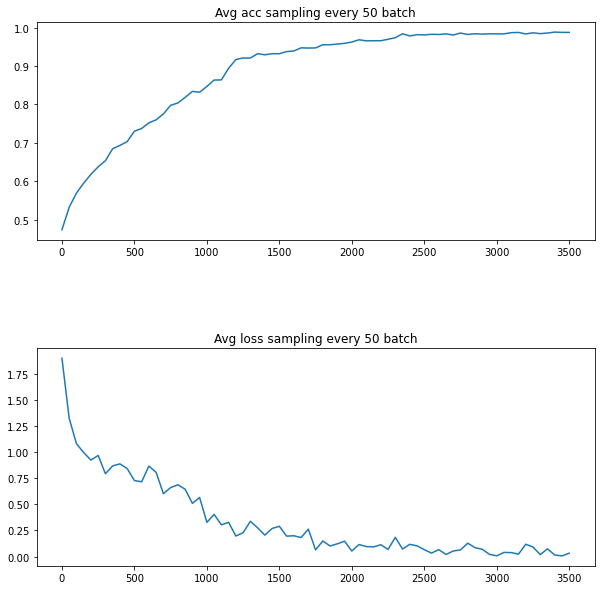

<Figure size 432x288 with 0 Axes>

In [12]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1,)
ax1.plot(x_label,new_acc)
ax1.set_title('Avg acc sampling every {} batch'.format(batch_step))
ax2 = plt.subplot(2,1,2,sharex=ax1)
ax2.plot(x_label,new_loss)
ax2.set_title('Avg loss sampling every {} batch'.format(batch_step))
plt.subplots_adjust(wspace =0, hspace =0.5)
plt.show()
plt.savefig('./img/{}-{}-acc-loss.jpg'.format(LEARN_RATE,MAX_SEQ_LENGTH))

In [13]:
#visualization
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
iterator = train_val_loaders
true_labels = []
pred_labels = []

model.eval()
tkz = AutoTokenizer.from_pretrained(MODEL_NAME)
with torch.no_grad():
    for ba,data in enumerate(notetqdm(iterator['valid'])):
        features = data['input_ids'].cuda()
        att_mask = data['attention_mask'].cuda()
        targets = data['targets']
        origins = data['origin_contents']
        targets.numpy()
        # print(len(origins), len(targets))
        true_labels += targets.tolist()
        outputs = model(features,att_mask)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.argmax(outputs, axis=1)
        # print screen 
        # print(len(data))
        '''
        
        for i in range(len(origins)):
            print("idx:{}".format(i))
            print(origins[i])
            print('pred: ',target_label[outputs[i]])
            print('true: ',source_label[targets[i]])
            print('--------------')
        '''
        pred_labels += outputs.tolist()
    print(len(true_labels))
    print(true_labels[:15])
    print(len(pred_labels))
    print(pred_labels[:15])
        

  0%|          | 0/252 [00:00<?, ?it/s]

32222
[3, 0, 3, 3, 0, 3, 4, 2, 3, 3, 2, 4, 3, 5, 3]
32222
[3, 0, 3, 3, 0, 3, 4, 2, 3, 3, 2, 4, 3, 5, 3]


7 7


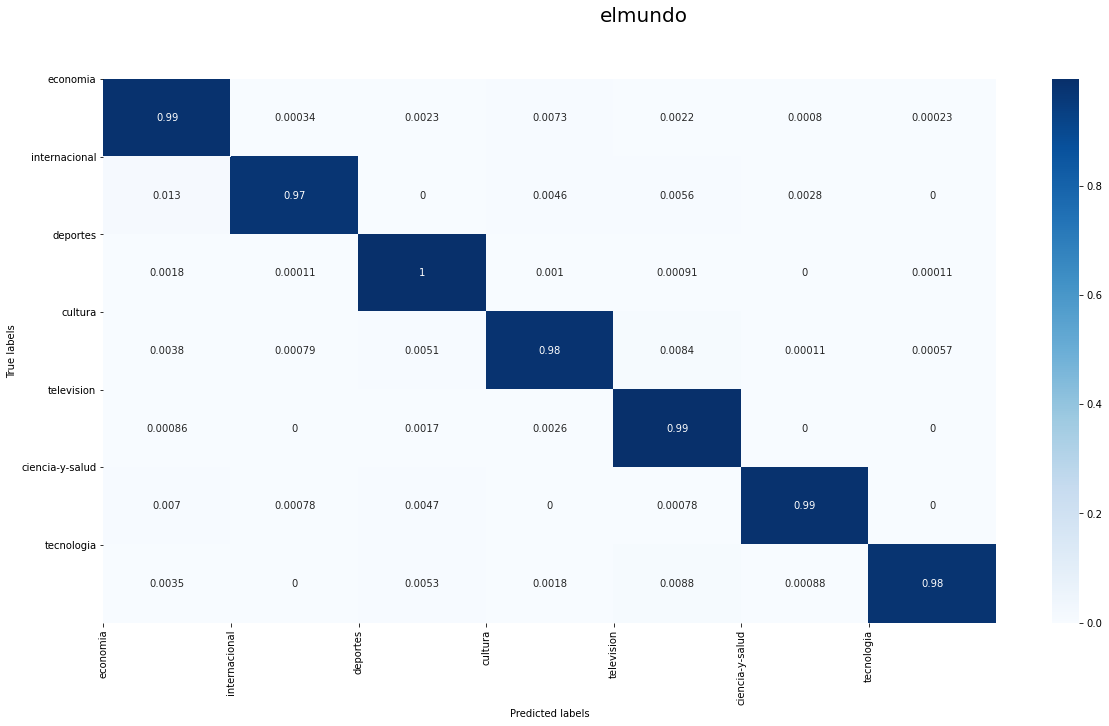

In [15]:
true_cate = [source_label[i] for i in true_labels]
pred_cate = [target_label[j] for j in pred_labels]

con_mat = confusion_matrix(true_cate,pred_cate)
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # nomalization
con_mat_norm = np.around(con_mat_norm, decimals=2)

# =====diy confusion matrix=====
matrix = [[0 for i in range(len(target_label))] for j in range(len(source_label))]
print(len(matrix),len(matrix[0]))
sums = [0 for i in range(len(source_label))]
for x,y in  zip(true_labels,pred_labels):
    matrix[x][y] += 1
    sums[x] += 1
# normalization
for i in range(len(source_label)):
    for j in range(len(target_label)):
        matrix[i][j] /= sums[i]
    
# === plot ===
fig = plt.figure(figsize=(20, 10))
sns.heatmap(matrix, annot=True, cmap='Blues')
catex = list(range(0,len(target_label),1))
catey = list(range(0,len(source_label),1))
fig.suptitle('elmundo',fontsize=20)

plt.xlabel('Predicted labels')
plt.xticks(catex,target_label)
plt.xticks(rotation=90)

plt.ylabel('True labels')
plt.yticks(catey,source_label)
plt.yticks(rotation=360)
plt.show()
# plt.savefig('./img/{}-{}-matrix.jpg'.format(init_lr,MAX_SEQ_LENGTH))